In [5]:
import imageio 
from skimage.transform import resize
from skimage import measure
from scipy import ndimage
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2
import sys

from net import *
from data import *

sys.path.append('./utils/')
from util import *

In [6]:
# invert the color of wall line and background for presentation
floorplan_fuse_map_figure = {
	0: [255,255,255], # background
	1: [192,192,224], # closet
	2: [192,255,255], # batchroom/washroom
	3: [224,255,192], # livingroom/kitchen/dining room
	4: [255,224,128], # bedroom
	5: [255,160, 96], # hall
	6: [255,224,224], # balcony
	7: [224,224,224], # not used
	8: [224,224,128], # not used
	9: [255,60,128],  # extra label for opening (door&window)
	10: [ 0, 0,  0]  # extra label for wall line
}

label_idx = [["Closet/storageroom", "purple", 1, 200],
             ["Bathroom/washroom",   "blue", 2, 120],
             ["Livingroom/kitchen/diningroom", "green", 3, 120],
             ["Bedrooms", "yellow", 4, 120],
             ["Halls", "orange", 5, 200],
             ["Doors/windows", "pink", 9, 80]]

def rgb2ind(im, color_map=floorplan_fuse_map_figure):
	ind = np.zeros((im.shape[0], im.shape[1]))

	for i, rgb in color_map.items():
		ind[(im==rgb).all(2)] = i

	# return ind.astype(int) # int => int64
	return ind.astype(np.uint8) # force to uint8

def ind2rgb(ind_im, color_map=floorplan_fuse_map_figure):
	rgb_im = np.zeros((ind_im.shape[0], ind_im.shape[1], 3))

	for i, rgb in color_map.items():
		rgb_im[(ind_im==i)] = rgb

	return rgb_im


# select the index file but remove .index

def init_model(path_weights):

  # read in a random image just to set up the model 
  path = './demo/45719584.jpg'
  img = image.load_img(path,target_size=(512,512,3))
  x = image.img_to_array(img)
  x = np.expand_dims(x,axis=0)
  x = preprocess_input(x)

  # initialize the model 
  model = deepfloorplanModel()
  logits_r, logits_cw = model(x) 

  # restore weights from previous training
  model.load_weights(path_weights) 

  return model 

def process_img(path, model):

  im = imageio.imread(path) #imagio read might need to be modified
  im = im.astype(np.float32)
  im = resize(im, (512,512,3)) / 255.
  x = np.expand_dims(im,axis=0)

  logits_r, logits_cw = model(x)

  # covert to image
  room_type = convert_one_hot_to_image(logits_r, act='softmax', dtype='int')
  room_boundary = convert_one_hot_to_image(logits_cw, act='softmax', dtype='int')

  # reshape it
  room_type = np.squeeze(room_type)
  room_boundary = np.squeeze(room_boundary)

  # merge results
  floorplan = room_type.copy()

  # merge results
  floorplan = room_type.copy()
  floorplan[room_boundary==1] = 9 # door & window, turning pink 
  floorplan[room_boundary==2] = 10 #wall, turning black 
  floorplan_rgb = ind2rgb(floorplan, color_map=floorplan_fuse_map_figure)

  # post-process
  im_ind = rgb2ind(floorplan_rgb, color_map=floorplan_fuse_map_figure)

  rm_ind = im_ind.copy()
  rm_ind[im_ind==9] = 0
  rm_ind[im_ind==10] = 0

  bd_ind = np.zeros(im_ind.shape, dtype=np.uint8)
  bd_ind[im_ind==9] = 9
  bd_ind[im_ind==10] = 10

  hard_c = (bd_ind>0).astype(np.uint8)

  # region from room prediction it self
  rm_mask = np.zeros(rm_ind.shape)
  rm_mask[rm_ind>0] = 1			
  # region from close_wall line		
  cw_mask = hard_c
  # refine close wall mask by filling the grap between bright line	
  cw_mask = fill_break_line(cw_mask)

  fuse_mask = cw_mask + rm_mask
  fuse_mask[fuse_mask>=1] = 255

  # refine fuse mask by filling the hole
  fuse_mask = flood_fill(fuse_mask)
  fuse_mask = fuse_mask // 255	

  # one room one label
  new_rm_ind = refine_room_region(cw_mask, rm_ind)

  # ignore the background mislabeling
  new_rm_ind = fuse_mask*new_rm_ind

  new_rm_ind[bd_ind==9] = 9
  new_rm_ind[bd_ind==10] = 10
  rgb = ind2rgb(new_rm_ind, color_map=floorplan_fuse_map_figure)

  # plot results
  plt.figure(figsize=(15, 15))
  plt.subplot(131)
  plt.imshow(im)
  plt.subplot(132)
  plt.imshow(floorplan_rgb/255.)
  plt.subplot(133)
  plt.imshow(rgb/255.)
  plt.show()

  return new_rm_ind

def count_comparts(processed_image, room_label, pixel):
  labels = measure.label(processed_image == room_label, connectivity=2)  
  properties = measure.regionprops(labels)
  valid_label = set()
  for prop in properties:
    if prop.area > pixel:
        valid_label.add(prop.label)
  return len(valid_label)


def print_comparts(processed_image):
  for i in range(len(label_idx)):
    result = "{:<30} {:<10} {:<2}".format(label_idx[i][0], 
                                          label_idx[i][1], 
                                          count_comparts(processed_image, label_idx[i][2], label_idx[i][3]))
    print(result)


def main():
    # initiate the model
    path_weights = './Jan12/G'
    model = init_model(path_weights = path_weights)

    # process and display the image
    demo_path = './demo/45719584.jpg'
    processed = process_img(demo_path, model)

    # count the compartments
    print_comparts(processed)

In [7]:
# initiate the model
path_weights = './Jan12/G'
model = init_model(path_weights = path_weights)

./utils/util.py:26: UserWarning: ignoring size because footprint is set
  output_array = np.maximum(input_array,ndimage.grey_erosion(output_array, size=(3,3), footprint=el))


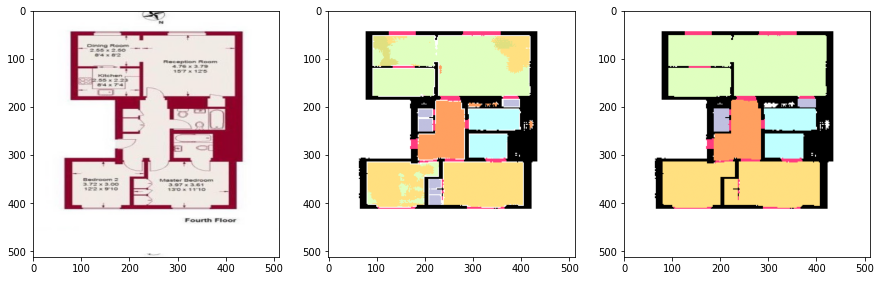

In [10]:
# process and display the image
demo_path = './demo/45719584.jpg'
processed = process_img(demo_path, model)

In [11]:
# count the compartments
print_comparts(processed)

Closet/storageroom             purple     2 
Bathroom/washroom              blue       2 
Livingroom/kitchen/diningroom  green      2 
Bedrooms                       yellow     2 
Halls                          orange     1 
Doors/windows                  pink       13
